In [3]:
import torch
print(torch.cuda.is_available()) # should be True
# t = torch.rand(10, 10).cuda()
# print(t.device) # should be CUDA]
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
from PIL import Image
import os
import nibabel as nib
import matplotlib.pyplot as plt
import torchio as tio



True


/home/adil/Documents/TUE/preparationPhase/myProject/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Change detection (invariant to angles) 2D

### Before starting
- Run both bash scripts in ./data/raw/postop and ./data/raw/preop to mask the anat/T1w.nii.gz data 
- Run the script in ./data/preprocessed/postop and ./data/preprocessed/preop to align the T1.ants

In [4]:
#!bash data/processed/postop/align_script.sh

Entering directory: data/processed/postop/BTC-postop/sub-CON02/ in data/processed/postop/BTC-postop
Processing subject: sub-CON02
Finished processing subject sub-CON02
Entering directory: data/processed/postop/BTC-postop/sub-CON03/ in data/processed/postop/BTC-postop
Processing subject: sub-CON03
Finished processing subject sub-CON03
Entering directory: data/processed/postop/BTC-postop/sub-CON04/ in data/processed/postop/BTC-postop
Processing subject: sub-CON04
Finished processing subject sub-CON04
Entering directory: data/processed/postop/BTC-postop/sub-CON05/ in data/processed/postop/BTC-postop
Processing subject: sub-CON05
Finished processing subject sub-CON05
Entering directory: data/processed/postop/BTC-postop/sub-CON06/ in data/processed/postop/BTC-postop
Processing subject: sub-CON06
Finished processing subject sub-CON06
Entering directory: data/processed/postop/BTC-postop/sub-CON07/ in data/processed/postop/BTC-postop
Processing subject: sub-CON07
Finished processing subject su

In [ ]:
#!bash data/raw/postop/mask_script.sh
#!bash data/raw/preop/mask_script.sh

### Tasks:
- ~~use preprocessed (/home/adil/Documents/TUE/preparationPhase/myProject/data/processed/postop/BTC-postop/sub-CON02/T1_ants.nii.gz)~~
- ~~align them using fsl flirt~~
- ~~Finish background~~
- Request compute and find a way to group slices or somethin?
- ~~paper -> edit neuroplasticity and edit the ??? to related works~~
- Read the similarity learning thesis and follow-up (https://research.tue.nl/en/studentTheses/aspect-based-few-shot-learning)
- add data source https://www.nature.com/articles/s41597-022-01806-4
- ~~add research aim~~

Maxime
- ask which files are adc/dti and how to interpret an adc (no orientation?)
- What kind of preprocessing is done on the data
- are files correctly aligned?
- How do we do the compute thing?

andre & maxime
- usage of torchio and the lossy transforms
- 

### Util functions

In [2]:
def remove_images_in_sub_dir(directory):

    for root, dirs, files in os.walk(directory):
        for filename in files:
            print(filename)
            if os.path.isfile(os.path.join(root, filename)) and filename.lower().endswith('.jpg'):
                os.remove(os.path.join(root,filename))

### Start with axial, coronal, saggital midpoint images

In [3]:
def convert_to_image_if_not_exist(directory, output_size=(256, 256), second_dir=None, image_id='mask.nii.gz', ext='nii.gz'):
    angle_map = {
        'saggital': 0,
        'coronal': 1,
        'axial': 2
    }
    for root, dirs, files in os.walk(directory):
        for filename in files:
            if filename.endswith(image_id):
                # Construct input and output paths
                input_path = os.path.join(root, filename)
                nifti_data = nib.load(input_path)
                image_data = nifti_data.get_fdata()
                for key, value in angle_map.items():

                    output_path = os.path.join(root, filename.replace(ext, "") + f"{key}" + ".jpg")
                    # Check if output image already exists
                    if os.path.exists(output_path):
                        print(f"Image {output_path} already exists, skipping...") 
                        continue
                    slicing_tuple = [slice(None)] * len(image_data.shape)
                    slice_index = image_data.shape[value] // 2
                    slicing_tuple[value] = slice_index

                    # Apply the slicing to image_data
                    image_slice = image_data[tuple(slicing_tuple)]

                    # Normalize intensity values
                    min_intensity = np.min(image_slice)
                    max_intensity = np.max(image_slice)
                    image_slice_normalized = (image_slice - min_intensity) / (max_intensity - min_intensity)

                    # Resize the slice to the specified output size
                    image_slice_resized = np.array(Image.fromarray((image_slice_normalized * 255).astype(np.uint8)).resize(output_size))

                    # Convert to image format
                    image = Image.fromarray(image_slice_resized)

                    # Resize the image to the specified output size
                    image = image.resize(output_size)
                    image.save(output_path)
                    if second_dir is not None:
                        output_dir = os.path.join(second_dir, filename.split('_')[0])
                        os.makedirs(output_dir, exist_ok=True)
                # Save the image
                        image.save(os.path.join(f'{second_dir}/{filename.split("_")[0]}', os.path.splitext(filename)[0] + f"{key}" + ".jpg"))
                    print(f"Converted image {input_path} to {output_path} with size {output_size}")

### Converting raw preop

In [4]:
dir = "./data/raw/preop/BTC-preop"
output_size = (256, 256)  # Specify the desired output size
#convert the masked images
convert_to_image_if_not_exist(dir, output_size, image_id='mask.nii.gz', ext='nii.gz')
#convert the original images
convert_to_image_if_not_exist(dir, output_size, image_id='T1w.nii.gz', ext='nii.gz')

Image ./data/raw/preop/BTC-preop/sub-PAT31/ses-preop/anat/sub-PAT31_ses-preop_T1w.nii_mask.saggital.jpg already exists, skipping...
Image ./data/raw/preop/BTC-preop/sub-PAT31/ses-preop/anat/sub-PAT31_ses-preop_T1w.nii_mask.coronal.jpg already exists, skipping...
Image ./data/raw/preop/BTC-preop/sub-PAT31/ses-preop/anat/sub-PAT31_ses-preop_T1w.nii_mask.axial.jpg already exists, skipping...
Image ./data/raw/preop/BTC-preop/sub-CON09/ses-preop/anat/sub-CON09_ses-preop_T1w.nii_mask.saggital.jpg already exists, skipping...
Image ./data/raw/preop/BTC-preop/sub-CON09/ses-preop/anat/sub-CON09_ses-preop_T1w.nii_mask.coronal.jpg already exists, skipping...
Image ./data/raw/preop/BTC-preop/sub-CON09/ses-preop/anat/sub-CON09_ses-preop_T1w.nii_mask.axial.jpg already exists, skipping...
Image ./data/raw/preop/BTC-preop/sub-CON03/ses-preop/anat/sub-CON03_ses-preop_T1w.nii_mask.saggital.jpg already exists, skipping...
Image ./data/raw/preop/BTC-preop/sub-CON03/ses-preop/anat/sub-CON03_ses-preop_T1w.ni

### Converting raw postop

In [5]:
dir = "./data/raw/postop/BTC-postop"
output_size = (256, 256)  # Specify the desired output size
#convert the masked images
convert_to_image_if_not_exist(dir, output_size, image_id='mask.nii.gz', ext='nii.gz')
#convert the original images
convert_to_image_if_not_exist(dir, output_size, image_id='T1w.nii.gz', ext='nii.gz')

Image ./data/raw/postop/BTC-postop/sub-CON09/ses-postop/anat/sub-CON09_ses-postop_T1w.nii_mask.saggital.jpg already exists, skipping...
Image ./data/raw/postop/BTC-postop/sub-CON09/ses-postop/anat/sub-CON09_ses-postop_T1w.nii_mask.coronal.jpg already exists, skipping...
Image ./data/raw/postop/BTC-postop/sub-CON09/ses-postop/anat/sub-CON09_ses-postop_T1w.nii_mask.axial.jpg already exists, skipping...
Image ./data/raw/postop/BTC-postop/sub-CON03/ses-postop/anat/sub-CON03_ses-postop_T1w.nii_mask.saggital.jpg already exists, skipping...
Image ./data/raw/postop/BTC-postop/sub-CON03/ses-postop/anat/sub-CON03_ses-postop_T1w.nii_mask.coronal.jpg already exists, skipping...
Image ./data/raw/postop/BTC-postop/sub-CON03/ses-postop/anat/sub-CON03_ses-postop_T1w.nii_mask.axial.jpg already exists, skipping...
Image ./data/raw/postop/BTC-postop/sub-PAT25/ses-postop/anat/sub-PAT25_ses-postop_T1w.nii_mask.saggital.jpg already exists, skipping...
Image ./data/raw/postop/BTC-postop/sub-PAT25/ses-postop/

### Converting processed preop

In [6]:
dir = "./data/processed/preop/BTC-preop"
output_size = (256, 256)  # Specify the desired output size
#convert the FA images
convert_to_image_if_not_exist(dir, output_size, image_id='fa.nii.gz', ext='nii.gz')
#convert the MD images
convert_to_image_if_not_exist(dir, output_size, image_id='md.nii.gz', ext='nii.gz')

Image ./data/processed/preop/BTC-preop/sub-PAT31/dti/fa.saggital.jpg already exists, skipping...
Image ./data/processed/preop/BTC-preop/sub-PAT31/dti/fa.coronal.jpg already exists, skipping...
Image ./data/processed/preop/BTC-preop/sub-PAT31/dti/fa.axial.jpg already exists, skipping...
Image ./data/processed/preop/BTC-preop/sub-CON09/dti/fa.saggital.jpg already exists, skipping...
Image ./data/processed/preop/BTC-preop/sub-CON09/dti/fa.coronal.jpg already exists, skipping...
Image ./data/processed/preop/BTC-preop/sub-CON09/dti/fa.axial.jpg already exists, skipping...
Image ./data/processed/preop/BTC-preop/sub-CON03/dti/fa.saggital.jpg already exists, skipping...
Image ./data/processed/preop/BTC-preop/sub-CON03/dti/fa.coronal.jpg already exists, skipping...
Image ./data/processed/preop/BTC-preop/sub-CON03/dti/fa.axial.jpg already exists, skipping...
Image ./data/processed/preop/BTC-preop/sub-PAT25/dti/fa.saggital.jpg already exists, skipping...
Image ./data/processed/preop/BTC-preop/sub

### Converting processed postop

In [8]:
dir = "./data/processed/postop/BTC-postop"
output_size = (256, 256)  # Specify the desired output size
#convert the FA images
convert_to_image_if_not_exist(dir, output_size, image_id='fa.nii.gz', ext='nii.gz')
#convert the MD images
convert_to_image_if_not_exist(dir, output_size, image_id='md.nii.gz', ext='nii.gz')

Image ./data/processed/postop/BTC-postop/sub-CON09/dti/fa.saggital.jpg already exists, skipping...
Image ./data/processed/postop/BTC-postop/sub-CON09/dti/fa.coronal.jpg already exists, skipping...
Image ./data/processed/postop/BTC-postop/sub-CON09/dti/fa.axial.jpg already exists, skipping...
Image ./data/processed/postop/BTC-postop/sub-CON03/dti/fa.saggital.jpg already exists, skipping...
Image ./data/processed/postop/BTC-postop/sub-CON03/dti/fa.coronal.jpg already exists, skipping...
Image ./data/processed/postop/BTC-postop/sub-CON03/dti/fa.axial.jpg already exists, skipping...
Image ./data/processed/postop/BTC-postop/sub-PAT25/dti/fa.saggital.jpg already exists, skipping...
Image ./data/processed/postop/BTC-postop/sub-PAT25/dti/fa.coronal.jpg already exists, skipping...
Image ./data/processed/postop/BTC-postop/sub-PAT25/dti/fa.axial.jpg already exists, skipping...
Image ./data/processed/postop/BTC-postop/sub-PAT05/dti/fa.saggital.jpg already exists, skipping...
Image ./data/processed

### Datasets and dataloaders

In [7]:
class imageSets(Dataset):
    """
    Image dataset for each subject in the dataset
    creating only 'correct' and 'incorrect' pairs for now

    Works by passing preop or postop directory to the class
    and finds the corresponding image in the other dir and labels
    """
    def __init__(self, root, image_ids, transform=None):
        self.root = root
        self.transform = transform
        self.data = []
        self.image_ids = image_ids
        for root, dirs, files in os.walk(self.root):
            for filename in files:
                for image_id in self.image_ids:
                    if filename.endswith(image_id):
                        img_1 = Image.open(os.path.join(root, filename))
                        ## finds the corresponding image in the other dir
                        try:
                            if "preop" in root:
                                img_2 = Image.open(os.path.join(root.replace("preop", "postop"), filename.replace("preop", "postop")))
                            else:
                                img_2 = Image.open(os.path.join(root.replace("postop", "preop"), filename.replace("postop", "preop")))
                            if "-CON" in filename or "-CON" in os.path.join(root, filename):
                                # print("control for ", filename)
                                self.data.append((img_1, img_2, 1, os.path.join(root, filename))) # Similar
                            elif "-PAT" in filename or "-PAT" in os.path.join(root, filename):
                                self.data.append((img_1, img_2, 0, os.path.join(root, filename))) # Dissimalar
                            else:
                                print(f"Invalid filename: {os.path.join(root, filename)}")
                        except FileNotFoundError:
                            print(f"Matching subject (pre and post) not found for {os.path.join(root, filename)}")
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        if self.transform:
            img1_file = self.transform(self.data[idx][0])
            img2_file = self.transform(self.data[idx][1])
        return (img1_file, img2_file, self.data[idx][2], self.data[idx][3])

#### Datasets

In [5]:
default_transform = transforms.Compose([
transforms.Resize(256),
transforms.ToTensor(),
])
BATCH_SIZE = 1
raw_mask_data = imageSets('./data/raw/preop/BTC-preop', 
                       image_ids=['nii_mask.saggital.jpg', 'nii_mask.coronal.jpg', 'nii_mask.axial.jpg'], 
                       transform=default_transform)

raw_unmasked_data = imageSets('./data/raw/preop/BTC-preop', 
                          image_ids=['T1w.saggital.jpg', 'T1w.axial.jpg', 'T1w.coronal.jpg'],
                            transform=default_transform)
md_data = imageSets('./data/processed/preop/BTC-preop', 
                       image_ids=['md.saggital.jpg', 'md.axial.jpg', 'md.coronal.jpg'], 
                       transform=default_transform)
fa_data = imageSets('./data/processed/preop/BTC-preop', 
                          image_ids=['fa.saggital.jpg', 'fa.axial.jpg', 'fa.coronal.jpg'],
                            transform=default_transform)

Matching subject (pre and post) not found for ./data/raw/preop/BTC-preop/sub-PAT31/ses-preop/anat/sub-PAT31_ses-preop_T1w.nii_mask.saggital.jpg
Matching subject (pre and post) not found for ./data/raw/preop/BTC-preop/sub-PAT31/ses-preop/anat/sub-PAT31_ses-preop_T1w.nii_mask.axial.jpg
Matching subject (pre and post) not found for ./data/raw/preop/BTC-preop/sub-PAT31/ses-preop/anat/sub-PAT31_ses-preop_T1w.nii_mask.coronal.jpg
Matching subject (pre and post) not found for ./data/raw/preop/BTC-preop/sub-PAT14/ses-preop/anat/sub-PAT14_ses-preop_T1w.nii_mask.saggital.jpg
Matching subject (pre and post) not found for ./data/raw/preop/BTC-preop/sub-PAT14/ses-preop/anat/sub-PAT14_ses-preop_T1w.nii_mask.coronal.jpg
Matching subject (pre and post) not found for ./data/raw/preop/BTC-preop/sub-PAT14/ses-preop/anat/sub-PAT14_ses-preop_T1w.nii_mask.axial.jpg
Matching subject (pre and post) not found for ./data/raw/preop/BTC-preop/sub-CON01/ses-preop/anat/sub-CON01_ses-preop_T1w.nii_mask.saggital.jpg


#### Dataset splits

In [11]:
train_raw_mask, val_raw_mask, test_raw_mask = random_split(raw_mask_data, (0.6, 0.2, 0.2))
train_raw_unmasked, val_raw_unmasked, test_raw_unmasked = random_split(raw_unmasked_data, (0.6, 0.2, 0.2))
train_md, val_md, test_md = random_split(md_data, (0.6, 0.2, 0.2))
train_fa, val_fa, test_fa = random_split(fa_data, (0.6, 0.2, 0.2))


#### Loaders

In [12]:
train_loader_mask = DataLoader(train_raw_mask, batch_size=BATCH_SIZE, shuffle=False)
val_loader_mask = DataLoader(val_raw_mask, batch_size=BATCH_SIZE, shuffle=False)
test_loader_mask = DataLoader(test_raw_mask, batch_size=BATCH_SIZE, shuffle=False)

train_loader_unmasked = DataLoader(train_raw_unmasked, batch_size=BATCH_SIZE, shuffle=False)
val_loader_unmasked = DataLoader(val_raw_unmasked, batch_size=BATCH_SIZE, shuffle=False)
test_loader_unmasked = DataLoader(test_raw_unmasked, batch_size=BATCH_SIZE, shuffle=False)

train_loader_md = DataLoader(train_md, batch_size=BATCH_SIZE, shuffle=False)
val_loader_md = DataLoader(val_md, batch_size=BATCH_SIZE, shuffle=False)
test_loader_md = DataLoader(test_md, batch_size=BATCH_SIZE, shuffle=False)

train_loader_fa = DataLoader(train_fa, batch_size=BATCH_SIZE, shuffle=False)
val_loader_fa = DataLoader(val_fa, batch_size=BATCH_SIZE, shuffle=False)
test_loader_fa = DataLoader(test_fa, batch_size=BATCH_SIZE, shuffle=False)

### Network

In [58]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # Define the architecture for the Siamese network
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(131072, 128)  # Adjust input size based on input dimensions

    def forward(self, input1, input2):
        # Forward pass through the Siamese network
        output1 = F.relu(self.bn1(self.conv1(input1)))
        output1 = F.max_pool2d(output1, kernel_size=2, stride=2)
        output1 = F.relu(self.bn2(self.conv2(output1)))
        output1 = F.max_pool2d(output1, kernel_size=2, stride=2)
        output1 = F.relu(self.bn3(self.conv3(output1)))
        output1 = F.max_pool2d(output1, kernel_size=2, stride=2)

        output2 = F.relu(self.bn1(self.conv1(input2)))
        output2 = F.max_pool2d(output2, kernel_size=2, stride=2)
        output2 = F.relu(self.bn2(self.conv2(output2)))
        output2 = F.max_pool2d(output2, kernel_size=2, stride=2)
        output2 = F.relu(self.bn3(self.conv3(output2)))
        output2 = F.max_pool2d(output2, kernel_size=2, stride=2)

        return output1, output2



## Loss Functions

In [15]:
class ConstractiveLoss(nn.Module):

    def __init__(self,margin =2.0,dist_flag='l2'):
        super(ConstractiveLoss, self).__init__()
        self.margin = margin
        self.dist_flag = dist_flag

    def various_distance(self,out_vec_t0,out_vec_t1):

        if self.dist_flag == 'l2': # Euclidean distance
            distance = F.pairwise_distance(out_vec_t0,out_vec_t1,p=2)
        if self.dist_flag == 'l1': # Manhattan distance
            distance = F.pairwise_distance(out_vec_t0,out_vec_t1,p=1)
        if self.dist_flag == 'cos':# Cosine similarity
            similarity = F.cosine_similarity(out_vec_t0,out_vec_t1)
            distance = 1 - 2 * similarity/np.pi
        return distance

    def forward(self,out_vec_t0,out_vec_t1,label):
        distance = self.various_distance(out_vec_t0,out_vec_t1)
        constractive_loss = torch.sum((1-label)*torch.pow(distance,2 ) + \
                                       label * torch.pow(torch.clamp(self.margin - distance, min=0.0),2))
        return constractive_loss
    
class ConstractiveThresholdHingeLoss(nn.Module):

    def __init__(self,hingethresh=0.0,margin=2.0):
        super(ConstractiveThresholdHingeLoss, self).__init__()
        self.threshold = hingethresh
        self.margin = margin

    def forward(self,out_vec_t0,out_vec_t1,label):

        distance = F.pairwise_distance(out_vec_t0,out_vec_t1,p=2)
        similar_pair = torch.clamp(distance - self.threshold,min=0.0)
        dissimilar_pair = torch.clamp(self.margin- distance,min=0.0)
        #dissimilar_pair = torch.clamp(self.margin-(distance-self.threshold),min=0.0)
        constractive_thresh_loss = torch.sum(
            (1-label)* torch.pow(similar_pair,2) + label * torch.pow(dissimilar_pair,2)
        )
        return constractive_thresh_loss

## Visualization

In [59]:
import cv2
def check_dir(dir):
    if not os.path.exists(dir):
        os.mkdir(dir)

def various_distance(out_vec_t0, out_vec_t1,dist_flag):
    if dist_flag == 'l2':
        distance = F.pairwise_distance(out_vec_t0, out_vec_t1, p=2)
    if dist_flag == 'l1':
        distance = F.pairwise_distance(out_vec_t0, out_vec_t1, p=1)
    if dist_flag == 'cos':
        distance = 1 - F.cosine_similarity(out_vec_t0, out_vec_t1)
    return distance

def merge_images(image1, image2, image3, output_path):
    # Create a new figure
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # Display each image on a separate subplot
    axs[0].imshow(image1, cmap="gray")
    axs[0].axis('off')
    axs[1].imshow(image2, cmap="gray")
    axs[1].axis('off')
    axs[2].imshow(image3)
    axs[2].axis('off')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Save the merged image
    plt.savefig(output_path)
    plt.close(fig)

def single_layer_similar_heatmap_visual(output_t0,output_t1,dist_flag):

    interp = nn.Upsample(size=[512,512], mode='bilinear')
    n, c, h, w = output_t0.data.shape
    out_t0_rz = torch.transpose(output_t0.view(c, h * w), 1, 0)
    out_t1_rz = torch.transpose(output_t1.view(c, h * w), 1, 0)
    distance = various_distance(out_t0_rz,out_t1_rz,dist_flag=dist_flag)
    # print(distance)
    similar_distance_map = distance.view(h,w).data.cpu().numpy()
    similar_distance_map_rz = interp(torch.from_numpy(similar_distance_map[np.newaxis, np.newaxis, :]))
    # print(similar_distance_map_rz)
    similar_dis_map_colorize = cv2.applyColorMap(np.uint8(255 * similar_distance_map_rz.data.cpu().numpy()[0][0]), cv2.COLORMAP_JET)
    return similar_dis_map_colorize


## Training

In [60]:
import os
import torch

def train(siamese_net, optimizer, criterion, train_loader, val_loader, epochs=100, patience=3, 
          save_dir='models', model_name='masked.pth'):
    print(f"Number of samples in training set: {len(train_loader)}")
    print(f"Number of samples in validation set: {len(val_loader)}")
    
    ## TODO: model train move down
    print("\nStarting training...")
    best_loss = float('inf')
    consecutive_no_improvement = 0
    
    for epoch in range(epochs):
        epoch_train_loss = 0.0
        epoch_val_loss = 0.0
        for i, (img1_set, img2_set, label, filename) in enumerate(train_loader):
            siamese_net.train()  # switch to training mode
            output1, output2 = siamese_net(img1_set, img2_set)
            loss = criterion(output1, output2, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
            
        # Validation loop
        siamese_net.eval()  # switch to evaluation mode
        with torch.no_grad():
            for i, (img1_set, img2_set, label, filename) in enumerate(val_loader):
                output1, output2 = siamese_net(img1_set, img2_set)
                loss = criterion(output1, output2, label)
                epoch_val_loss += loss.item()
        
        # Calculate average loss for the epoch
        avg_train_loss = epoch_train_loss / len(train_loader)
        avg_val_loss = epoch_val_loss / len(val_loader)
        
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        
        # Check for improvement in validation loss
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            consecutive_no_improvement = 0
            # Save the best model
            save_path = os.path.join(save_dir, model_name)
            torch.save(siamese_net.state_dict(), save_path)
            print(f'Saved best model to {save_path}')
        else:
            consecutive_no_improvement += 1
            if consecutive_no_improvement >= patience:
                print(f'Early stopping at epoch {epoch+1} as no improvement for {patience} consecutive epochs.')
                break


#### Masked model with 3 axis

In [173]:
## TODO: Adapt learning rate at the end, it seems to "swing" when finding the lowest loss
# Initialize Siamese network
siamese_net = SiameseNetwork()
# siamese_net = siamese_net.cuda()  # Move the network to GPU
save_dir = './models'
if os.path.exists(os.path.join(save_dir, 'masked.pth')):
    siamese_net.load_state_dict(torch.load(os.path.join(save_dir, 'masked.pth')))
    print('Loaded the best model')
else:
    criterion = ConstractiveLoss(margin=0.0)
    optimizer = optim.Adam(siamese_net.parameters(), lr=0.001)
    # Train the Siamese network
    train(siamese_net,  optimizer, criterion, train_loader=train_loader_mask, val_loader=val_loader_mask,
           epochs=200, patience=5, save_dir='./models', model_name='masked.pth')

Number of samples in training set: 53
Number of samples in validation set: 17

Starting training...
Epoch [1/200], Train Loss: 9172.5851, Val Loss: 8550.0277
Saved best model to ./models/masked.pth
Epoch [2/200], Train Loss: 5739.0044, Val Loss: 7483.5251
Saved best model to ./models/masked.pth
Epoch [3/200], Train Loss: 4820.2966, Val Loss: 6546.8669
Saved best model to ./models/masked.pth
Epoch [4/200], Train Loss: 4083.0644, Val Loss: 5293.5723
Saved best model to ./models/masked.pth
Epoch [5/200], Train Loss: 3434.0535, Val Loss: 4280.7000
Saved best model to ./models/masked.pth
Epoch [6/200], Train Loss: 2889.3630, Val Loss: 3768.0998
Saved best model to ./models/masked.pth
Epoch [7/200], Train Loss: 2434.0618, Val Loss: 3253.5077
Saved best model to ./models/masked.pth
Epoch [8/200], Train Loss: 2129.3090, Val Loss: 3640.4031
Epoch [9/200], Train Loss: 1807.9468, Val Loss: 2551.2327
Saved best model to ./models/masked.pth
Epoch [10/200], Train Loss: 1494.4591, Val Loss: 2391.4944

####  Raw unmasked model 3 axis

In [174]:
# Initialize Siamese network
siamese_net_unmasked = SiameseNetwork()
# siamese_net = siamese_net.cuda()  # Move the network to GPU
save_dir = './models'
if os.path.exists(os.path.join(save_dir, 'unmasked.pth')):
    siamese_net_unmasked.load_state_dict(torch.load(os.path.join(save_dir, 'unmasked.pth')))
    print('Loaded the best model')
else:
    criterion = ConstractiveLoss(margin=0.0)
    optimizer = optim.Adam(siamese_net_unmasked.parameters(), lr=0.001)
    # Train the Siamese network
    train(siamese_net_unmasked,  optimizer, criterion, train_loader=train_loader_unmasked,
           val_loader=val_loader_unmasked,
           epochs=200, patience=5, save_dir='./models', model_name='unmasked.pth')

Number of samples in training set: 53
Number of samples in validation set: 17

Starting training...
Epoch [1/200], Train Loss: 13197.9797, Val Loss: 9962.2657
Saved best model to ./models/unmasked.pth
Epoch [2/200], Train Loss: 6374.1449, Val Loss: 7344.6830
Saved best model to ./models/unmasked.pth
Epoch [3/200], Train Loss: 4467.9755, Val Loss: 4954.2699
Saved best model to ./models/unmasked.pth
Epoch [4/200], Train Loss: 3241.7962, Val Loss: 3980.5614
Saved best model to ./models/unmasked.pth
Epoch [5/200], Train Loss: 2498.9360, Val Loss: 2882.7439
Saved best model to ./models/unmasked.pth
Epoch [6/200], Train Loss: 2132.9837, Val Loss: 2742.6364
Saved best model to ./models/unmasked.pth
Epoch [7/200], Train Loss: 1747.0150, Val Loss: 2087.8561
Saved best model to ./models/unmasked.pth
Epoch [8/200], Train Loss: 1528.9593, Val Loss: 1818.9857
Saved best model to ./models/unmasked.pth
Epoch [9/200], Train Loss: 1266.1342, Val Loss: 1452.7523
Saved best model to ./models/unmasked.pth

#### Processed FA model 3 axis

In [66]:
# Initialize Siamese network
#TODO: more data and tinker with teh margin a lot
siamese_net_fa = SiameseNetwork()
# siamese_net = siamese_net.cuda()  # Move the network to GPU
save_dir = './models'
if os.path.exists(os.path.join(save_dir, 'fa.pth')):
    siamese_net_fa.load_state_dict(torch.load(os.path.join(save_dir, 'fa.pth')))
    print('Loaded the best model')
else:
    criterion = ConstractiveLoss(margin=0.5)
    optimizer = optim.Adam(siamese_net_fa.parameters(), lr=0.001)
    # Train the Siamese network
    train(siamese_net_fa,  optimizer, criterion, epochs=200, train_loader=train_loader_fa, val_loader=val_loader_fa,
          patience=5, save_dir='./models', 
           model_name='fa.pth')

Number of samples in training set: 53
Number of samples in validation set: 17

Starting training...
Epoch [1/200], Train Loss: 7385.2742, Val Loss: 2700.0461
Saved best model to ./models/fa.pth
Epoch [2/200], Train Loss: 2334.6996, Val Loss: 2106.4329
Saved best model to ./models/fa.pth
Epoch [3/200], Train Loss: 1839.6810, Val Loss: 1738.2230
Saved best model to ./models/fa.pth
Epoch [4/200], Train Loss: 1459.8457, Val Loss: 1383.0957
Saved best model to ./models/fa.pth
Epoch [5/200], Train Loss: 1240.7188, Val Loss: 1220.3990
Saved best model to ./models/fa.pth
Epoch [6/200], Train Loss: 1099.8333, Val Loss: 1082.6936
Saved best model to ./models/fa.pth
Epoch [7/200], Train Loss: 986.5201, Val Loss: 965.7794
Saved best model to ./models/fa.pth
Epoch [8/200], Train Loss: 903.3012, Val Loss: 892.5620
Saved best model to ./models/fa.pth
Epoch [9/200], Train Loss: 837.3269, Val Loss: 857.3129
Saved best model to ./models/fa.pth
Epoch [10/200], Train Loss: 775.2790, Val Loss: 765.4849
Sav

#### Processed MD model 3 axis

In [176]:
# Initialize Siamese network
siamese_net_md = SiameseNetwork()
# siamese_net = siamese_net.cuda()  # Move the network to GPU
save_dir = './models'
if os.path.exists(os.path.join(save_dir, 'md.pth')):
    siamese_net_md.load_state_dict(torch.load(os.path.join(save_dir, 'md.pth')))
    print('Loaded the best model')
else:
    criterion = ConstractiveLoss(margin=0.0)
    optimizer = optim.Adam(siamese_net_md.parameters(), lr=0.001)
    # Train the Siamese network
    train(siamese_net_md,  optimizer, criterion, epochs=200, patience=5, save_dir='./models',
          train_loader=train_loader_md, val_loader=val_loader_md, model_name='md.pth')

Number of samples in training set: 53
Number of samples in validation set: 17

Starting training...
Epoch [1/200], Train Loss: 4799.4286, Val Loss: 1957.2219
Saved best model to ./models/md.pth
Epoch [2/200], Train Loss: 1948.0477, Val Loss: 1682.2149
Saved best model to ./models/md.pth
Epoch [3/200], Train Loss: 1729.5017, Val Loss: 1766.3927
Epoch [4/200], Train Loss: 1504.4722, Val Loss: 1375.6276
Saved best model to ./models/md.pth
Epoch [5/200], Train Loss: 1293.0733, Val Loss: 1177.2281
Saved best model to ./models/md.pth
Epoch [6/200], Train Loss: 1119.9396, Val Loss: 1252.7055
Epoch [7/200], Train Loss: 1026.2922, Val Loss: 1019.0056
Saved best model to ./models/md.pth
Epoch [8/200], Train Loss: 902.1396, Val Loss: 921.8015
Saved best model to ./models/md.pth
Epoch [9/200], Train Loss: 761.2506, Val Loss: 694.5710
Saved best model to ./models/md.pth
Epoch [10/200], Train Loss: 653.0522, Val Loss: 648.7458
Saved best model to ./models/md.pth
Epoch [11/200], Train Loss: 566.0212,

## Prediction

### Load Models

In [67]:
# Initialize Siamese network
## TODO: Check val and test data distribution
siamese_net_masked = SiameseNetwork()
siamese_net_unmasked = SiameseNetwork()
siamese_net_fa = SiameseNetwork()
siamese_net_md = SiameseNetwork()

# load weights
siamese_net_masked.load_state_dict(torch.load('./models/masked.pth'))
siamese_net_unmasked.load_state_dict(torch.load('./models/unmasked.pth'))
siamese_net_fa.load_state_dict(torch.load('./models/fa.pth'))
siamese_net_md.load_state_dict(torch.load('./models/md.pth'))

<All keys matched successfully>

In [71]:
# Prediction function
## TODO: understand the heatmaps
def predict(siamese_net, image1, image2, threshold=0.3):
    siamese_net.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        output1, output2 = siamese_net(image1, image2)
        distance1 = various_distance(output1, output2, 'l2')  # Compute the distance euclidean
        distance = torch.dist(output1, output2, p=2)
        # print(f"Distance: {distance}")
        #similarity_score = 1 - distance.item()  # Convert distance to similarity score
        prediction = distance < threshold  # Determine if the pair is similar based on the threshold
    return prediction, output1, output2, distance.item()


### Unmasked raw data

In [55]:
# Prediction
# label 1 is similar, 0 is dissimilar
import matplotlib.pyplot as plt
for i, (img1_set, img2_set, label, filename) in enumerate(test_loader_unmasked):
    img_array = img1_set.squeeze().numpy()  # Remove the singleton dimensions and convert to NumPy array
    
    # Display the image using matplotlib
    # plt.imshow(img_array, cmap='gray')  # Assuming grayscale image
    # plt.axis('off')  # Turn off axis labels
    # plt.show()
    orig_filename = os.path.splitext(filename[0])[0]
    patient_id = orig_filename.split("/")[-1]
    is_similar, output1, output2, distance = predict(siamese_net_unmasked, img1_set, img2_set, 0.014)
    heatmap = single_layer_similar_heatmap_visual(output1,output2, 'l2')
    # plt.imshow(heatmap)
    # plt.axis('off')  # Turn off axis labels
    # plt.show()
    
    merge_images(img1_set[0][0].numpy(), img2_set[0][0].numpy(), heatmap, f'./data/heatmaps/raw/unmasked/{patient_id}.jpg')
    if is_similar:
        print("The pair is similar with a distance of:", distance, " label:", label)
    else:
        print("The pair is dissimilar with a distance of:", distance, " label:", label)

The pair is dissimilar with a distance of: 0.0  label: tensor([1])
The pair is dissimilar with a distance of: 0.0  label: tensor([1])
The pair is dissimilar with a distance of: 0.0  label: tensor([1])
The pair is dissimilar with a distance of: 0.0  label: tensor([1])
The pair is dissimilar with a distance of: 0.0  label: tensor([0])
The pair is dissimilar with a distance of: 0.0  label: tensor([1])
The pair is dissimilar with a distance of: 0.0  label: tensor([1])
The pair is dissimilar with a distance of: 0.0  label: tensor([1])
The pair is dissimilar with a distance of: 0.0  label: tensor([0])
The pair is dissimilar with a distance of: 0.012938280589878559  label: tensor([0])
The pair is dissimilar with a distance of: 0.0  label: tensor([0])
The pair is dissimilar with a distance of: 0.0  label: tensor([1])
The pair is dissimilar with a distance of: 0.0  label: tensor([0])
The pair is dissimilar with a distance of: 0.0  label: tensor([0])
The pair is dissimilar with a distance of: 0.

### Masked data

In [58]:
# Prediction
# label 1 is similar, 0 is dissimilar
for i, (img1_set, img2_set, label, filename) in enumerate(test_loader_mask):
    img_array = img1_set.squeeze().numpy()  # Remove the singleton dimensions and convert to NumPy array
    
    orig_filename = os.path.splitext(filename[0])[0]
    patient_id = orig_filename.split("/")[-1]
    is_similar, output1, output2, distance = predict(siamese_net_masked, img1_set, img2_set, 0.014)
    heatmap = single_layer_similar_heatmap_visual(output1,output2, 'l2')
    break
    # plt.imshow(heatmap)
    # plt.axis('off')  # Turn off axis labels
    # plt.show()
    
    merge_images(img1_set[0][0].numpy(), img2_set[0][0].numpy(), heatmap, f'./data/heatmaps/raw/masked/{patient_id}.jpg')
    if is_similar:
        print("The pair is similar with a distance of:", distance, " label:", label)
    else:
        print("The pair is dissimilar with a distance of:", distance, " label:", label)

tensor([[[[1.1314e-05, 1.1314e-05, 1.1314e-05,  ..., 1.1314e-05,
           1.1314e-05, 1.1314e-05],
          [1.1314e-05, 1.1314e-05, 1.1314e-05,  ..., 1.1314e-05,
           1.1314e-05, 1.1314e-05],
          [1.1314e-05, 1.1314e-05, 1.1314e-05,  ..., 1.1314e-05,
           1.1314e-05, 1.1314e-05],
          ...,
          [1.1314e-05, 1.1314e-05, 1.1314e-05,  ..., 1.1314e-05,
           1.1314e-05, 1.1314e-05],
          [1.1314e-05, 1.1314e-05, 1.1314e-05,  ..., 1.1314e-05,
           1.1314e-05, 1.1314e-05],
          [1.1314e-05, 1.1314e-05, 1.1314e-05,  ..., 1.1314e-05,
           1.1314e-05, 1.1314e-05]]]])


### FA

In [72]:
for i, (img1_set, img2_set, label, filename) in enumerate(test_loader_fa):
    img_array = img1_set.squeeze().numpy()  # Remove the singleton dimensions and convert to NumPy array
    orig_filename = os.path.splitext(filename[0])[0]
    axis = orig_filename.split("/")[-1]
    patient_id = orig_filename.split("/")[-3]
    is_similar, output1, output2, distance = predict(siamese_net_fa, img1_set, img2_set, 7.5)
    heatmap = single_layer_similar_heatmap_visual(output1,output2, 'l2')
    # plt.imshow(heatmap)
    # plt.axis('off')  # Turn off axis labels
    # plt.show()
    
    merge_images(img1_set[0][0].numpy(), img2_set[0][0].numpy(), heatmap, f'./data/heatmaps/processed/fa/{patient_id}_{axis}.jpg')
    if is_similar:
        print("The pair is similar with a distance of:", distance, " label:", label)
    else:
        print("The pair is dissimilar with a distance of:", distance, " label:", label)

The pair is dissimilar with a distance of: 8.120107650756836  label: tensor([0])
The pair is dissimilar with a distance of: 10.426508903503418  label: tensor([0])
The pair is dissimilar with a distance of: 10.437005043029785  label: tensor([0])
The pair is dissimilar with a distance of: 7.883455753326416  label: tensor([0])
The pair is dissimilar with a distance of: 9.908163070678711  label: tensor([0])
The pair is dissimilar with a distance of: 7.793230056762695  label: tensor([1])
The pair is dissimilar with a distance of: 11.00754165649414  label: tensor([0])
The pair is dissimilar with a distance of: 7.683225154876709  label: tensor([0])
The pair is similar with a distance of: 7.331306457519531  label: tensor([0])
The pair is dissimilar with a distance of: 12.752878189086914  label: tensor([1])
The pair is dissimilar with a distance of: 10.182259559631348  label: tensor([1])
The pair is dissimilar with a distance of: 11.542579650878906  label: tensor([0])
The pair is similar with a

: 

#### MD

In [38]:
for i, (img1_set, img2_set, label, filename) in enumerate(test_loader_md):
    img_array = img1_set.squeeze().numpy()  # Remove the singleton dimensions and convert to NumPy array

    orig_filename = os.path.splitext(filename[0])[0]
    patient_id = orig_filename.split("/")[-3]
    axis = orig_filename.split("/")[-1]
    is_similar, output1, output2, distance = predict(siamese_net_md, img1_set, img2_set, 0.014)
    heatmap = single_layer_similar_heatmap_visual(output1,output2, 'l2')
    
    merge_images(img1_set[0][0].numpy(), img2_set[0][0].numpy(), heatmap, f'./data/heatmaps/processed/md/{patient_id}_{axis}.jpg')
    if is_similar:
        print("The pair is similar with a distance of:", distance, " label:", label)
    else:
        print("The pair is dissimilar with a distance of:", distance, " label:", label)

The pair is dissimilar with a distance of: 0.0  label: tensor([1])
The pair is dissimilar with a distance of: 0.0  label: tensor([1])
The pair is dissimilar with a distance of: 0.0  label: tensor([1])
The pair is dissimilar with a distance of: 0.0  label: tensor([0])
The pair is dissimilar with a distance of: 0.0  label: tensor([0])
The pair is dissimilar with a distance of: 0.0  label: tensor([1])
The pair is dissimilar with a distance of: 0.0  label: tensor([1])
The pair is dissimilar with a distance of: 0.0  label: tensor([0])
The pair is dissimilar with a distance of: 0.0061670392751693726  label: tensor([0])
The pair is dissimilar with a distance of: 0.0  label: tensor([1])
The pair is similar with a distance of: 0.023047402501106262  label: tensor([0])
The pair is dissimilar with a distance of: 0.0  label: tensor([0])
The pair is dissimilar with a distance of: 0.0015739633236080408  label: tensor([1])
The pair is dissimilar with a distance of: 0.0  label: tensor([0])
The pair is 

## Visualization of latent space (Dim reduc? -> probably doesnt preserve numerical values (distance)..)

# Change detection (invariant to angles) 3D

### Torchio approach

In [14]:
def create_subject_pairs(root, id):
    data = []
    for root, dirs, files in os.walk(root):
        for filename in files:
            for image_id in id:
                if filename.endswith(image_id):
                    nifti_1 = tio.ScalarImage(os.path.join(root, filename))
                    ## finds the corresponding image in the other dir
                    try:
                        if "preop" in root:
                            nifti_2 = tio.ScalarImage(os.path.join(root.replace("preop", "postop"), filename.replace("preop", "postop")))
                        else:
                            nifti_2 = tio.ScalarImage(os.path.join(root.replace("postop", "preop"), filename.replace("postop", "preop")))
                        if "-CON" in filename or "-CON" in os.path.join(root, filename):
                            # print("control for ", filename)
                            data.append(
                                tio.Subject(
                                    t1=nifti_1,
                                    t2=nifti_2,
                                    label=1,
                                    path= os.path.join(root, filename)
                                            )
                                    )
                        elif "-PAT" in filename or "-PAT" in os.path.join(root, filename):
                                data.append(
                                tio.Subject(
                                    t1=nifti_1,
                                    t2=nifti_2,
                                    label=0,
                                    path= os.path.join(root, filename)
                                            )
                                    )
                        else:
                            print(f"Invalid filename: {os.path.join(root, filename)}")
                    except FileNotFoundError:
                        print(f"Matching subject (pre and post) not found for {os.path.join(root, filename)}")
    return data


'./data/processed/preop/BTC-preop/sub-CON03/t1_ants_aligned.nii.gz'

In [21]:
subjects_list = create_subject_pairs(root= './data/processed/preop/BTC-preop', id=['t1_ants_aligned.nii.gz'])
transforms = [
    # tio.RescaleIntensity(out_min_max=(0, 1)),
    tio.Resize((164, 164, 164)),
]
transform = tio.Compose(transforms)
subjects_dataset = tio.SubjectsDataset(subjects_list, transform=transform)
test_subject = subjects_dataset[1]
test_subject.path

'./data/processed/preop/BTC-preop/sub-CON03/t1_ants_aligned.nii.gz'

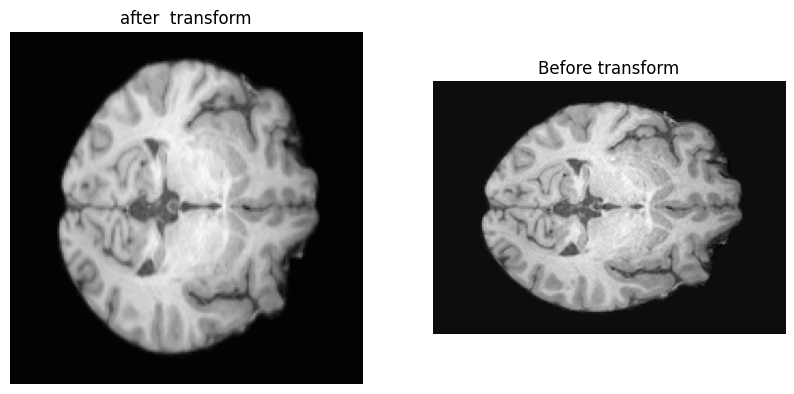

In [20]:
# Convert the TorchIO image to a numpy array and remove the channel dimension
t1_numpy = test_subject.t1.data.squeeze().numpy()
t1_numpy_orig = nib.load(test_subject.path).get_fdata()

resized_slice_index = int(test_subject.t1.spatial_shape[0] * (80 / t1_numpy_orig.shape[2]))

# Plot the original and T2 images
plt.figure(figsize=(10, 5))

# T2 image
plt.subplot(1, 2, 2)
plt.imshow(t1_numpy_orig[:, :, 80], cmap='gray')  # Assuming you want to visualize a slice at index 80
plt.title('Before transform')
plt.axis('off')

# Original image
plt.subplot(1, 2, 1)
plt.imshow(t1_numpy[:, :, resized_slice_index], cmap='gray')  # Assuming you want to visualize a slice at index 80
plt.title('after  transform')
plt.axis('off')



plt.show()


In [23]:
train_t1, val_t1, test_t1 = random_split(subjects_dataset, (0.6, 0.2, 0.2))
BATCH_SIZE=1
train_loader_t1 = DataLoader(train_t1, batch_size=BATCH_SIZE, shuffle=False)
val_loader_t1 = DataLoader(val_t1, batch_size=BATCH_SIZE, shuffle=False)
test_loader_t1 = DataLoader(test_t1, batch_size=BATCH_SIZE, shuffle=False)


In [102]:
class ConstractiveLoss(nn.Module):

    def __init__(self,margin =2.0,dist_flag='l2'):
        super(ConstractiveLoss, self).__init__()
        self.margin = margin
        self.dist_flag = dist_flag

    def various_distance(self,out_vec_t0,out_vec_t1):

        if self.dist_flag == 'l2': # Euclidean distance
            distance = F.pairwise_distance(out_vec_t0,out_vec_t1,p=2)
        if self.dist_flag == 'l1': # Manhattan distance
            distance = F.pairwise_distance(out_vec_t0,out_vec_t1,p=1)
        if self.dist_flag == 'cos':# Cosine similarity
            similarity = F.cosine_similarity(out_vec_t0,out_vec_t1)
            distance = 1 - 2 * similarity/np.pi
        return distance

    def forward(self,out_vec_t0,out_vec_t1,label):
        distance = self.various_distance(out_vec_t0,out_vec_t1)
        constractive_loss = torch.sum((1-label)*torch.pow(distance,2 ) + \
                                       label * torch.pow(torch.clamp(self.margin - distance, min=0.0),2))
        return constractive_loss
    
class ConstractiveThresholdHingeLoss(nn.Module):

    def __init__(self,hingethresh=0.0,margin=2.0):
        super(ConstractiveThresholdHingeLoss, self).__init__()
        self.threshold = hingethresh
        self.margin = margin

    def forward(self,out_vec_t0,out_vec_t1,label):

        distance = F.pairwise_distance(out_vec_t0,out_vec_t1,p=2)
        similar_pair = torch.clamp(distance - self.threshold,min=0.0)
        dissimilar_pair = torch.clamp(self.margin- distance,min=0.0)
        #dissimilar_pair = torch.clamp(self.margin-(distance-self.threshold),min=0.0)
        constractive_thresh_loss = torch.sum(
            (1-label)* torch.pow(similar_pair,2) + label * torch.pow(dissimilar_pair,2)
        )
        return constractive_thresh_loss

In [112]:
class SiameseThreeDim(nn.Module):
    def __init__(self):
        super(SiameseThreeDim, self).__init__()
        # Define the architecture for the Siamese network
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(32)
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(64)
        self.conv3 = nn.Conv3d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm3d(128)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(10, 128)  # Adjust input size based on input dimensions

    def forward(self, input1, input2):
        # Forward pass through the Siamese network
        output1 = F.relu(self.bn1(self.conv1(input1)))
        output1 = F.max_pool3d(output1, kernel_size=2, stride=2)
        output1 = F.relu(self.bn2(self.conv2(output1)))
        output1 = F.max_pool3d(output1, kernel_size=2, stride=2)
        output1 = F.relu(self.bn3(self.conv3(output1)))
        output1 = F.max_pool3d(output1, kernel_size=2, stride=2)

        output2 = F.relu(self.bn1(self.conv1(input2)))
        output2 = F.max_pool3d(output2, kernel_size=2, stride=2)
        output2 = F.relu(self.bn2(self.conv2(output2)))
        output2 = F.max_pool3d(output2, kernel_size=2, stride=2)
        output2 = F.relu(self.bn3(self.conv3(output2)))
        output2 = F.max_pool3d(output2, kernel_size=2, stride=2)

        return output1, output2

In [115]:

def train(siamese_net, optimizer, criterion, train_loader, val_loader, epochs=100, patience=3, 
          save_dir='models', model_name='masked.pth'):
    print(f"Number of samples in training set: {len(train_loader)}")
    print(f"Number of samples in validation set: {len(val_loader)}")
    
    ## TODO: model train move down
    print("\nStarting training...")
    best_loss = float('inf')
    consecutive_no_improvement = 0
    
    for epoch in range(epochs):
        epoch_train_loss = 0.0
        epoch_val_loss = 0.0
        for index, subject in enumerate(train_loader):
            siamese_net.train()  # switch to training mode
            output1, output2 = siamese_net(subject['t1']['data'].float(), subject['t2']['data'].float())
            loss = criterion(output1, output2, subject['label'])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
            
        # Validation loop
        siamese_net.eval()  # switch to evaluation mode
        with torch.no_grad():
            for index, subject in enumerate(val_loader):
                output1, output2 = siamese_net(subject['t1']['data'].float(), subject['t2']['data'].float())
                loss = criterion(output1, output2, subject['label'])
                epoch_val_loss += loss.item()
        
        # Calculate average loss for the epoch
        avg_train_loss = epoch_train_loss / len(train_loader)
        avg_val_loss = epoch_val_loss / len(val_loader)
        
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        
        # Check for improvement in validation loss
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            consecutive_no_improvement = 0
            # Save the best model
            save_path = os.path.join(save_dir, model_name)
            torch.save(siamese_net.state_dict(), save_path)
            print(f'Saved best model to {save_path}')
        else:
            consecutive_no_improvement += 1
            if consecutive_no_improvement >= patience:
                print(f'Early stopping at epoch {epoch+1} as no improvement for {patience} consecutive epochs.')
                break


In [116]:
siamese3Dnet = SiameseThreeDim()
# siamese3Dnet = siamese3Dnet.cuda()  # Move the network to GPU
save_dir = './models'
if os.path.exists(os.path.join(save_dir, '3d.pth')):
    siamese3Dnet.load_state_dict(torch.load(os.path.join(save_dir, '3d.pth')))
    print('Loaded the best model')
else:
    criterion = ConstractiveLoss(margin=0.3)
    optimizer = optim.Adam(siamese3Dnet.parameters(), lr=0.001)
    # Train the Siamese network
    train(siamese3Dnet,  optimizer, criterion, train_loader=train_loader_t1, val_loader=val_loader_t1,
           epochs=200, patience=5, save_dir='./models', model_name='3d.pth')

Number of samples in training set: 18
Number of samples in validation set: 6

Starting training...
torch.Size([164, 164, 164])
torch.Size([1, 1, 164, 164, 164])
torch.Size([164, 164, 164])
torch.Size([1, 1, 164, 164, 164])
torch.Size([164, 164, 164])
torch.Size([1, 1, 164, 164, 164])
torch.Size([164, 164, 164])
torch.Size([1, 1, 164, 164, 164])


KeyboardInterrupt: 